In [1]:
import pydicom as dcm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import radiomics


In [2]:
path_public_data = '/mnt/iDriveShare/OdetteR/PHD/PublicData/GLIS-RT/GLIS-RT/GLI_001_GBM/04-05-2008-BRAIN-81839/3.000000-2.55mm-72273'
#I:\OdetteR\PHD\PublicData\GLIS-RT\GLIS-RT\GLI_001_GBM\

In [3]:
ds = dcm.dcmread(path_public_data+'/1-002.dcm')

In [4]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.31949151924518114960315078426149235892
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20080405'
(0008, 0013) Instance Creation Time              TM: '101034'
(0008, 0016) SOP Class UID            

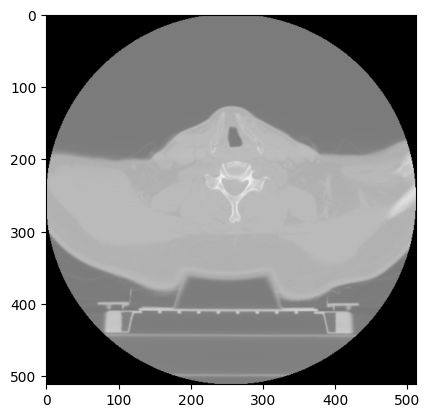

In [27]:
plt.imshow(ds.pixel_array,cmap='gray')

In [29]:
element = ds[0x00080008]
element

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']

In [35]:
ds[0x00080020]

(0008, 0020) Study Date                          DA: '20080405'

In [36]:
ds.KVP

"140.0"

In [46]:
ds[0x00180060].value, ds.get(0x00180060, None).value

("140.0", "140.0")

In [23]:
ds.get('Manufacturer')

'GE MEDICAL SYSTEMS'

In [14]:
dicts = {}

dicts['Image'] = 5

In [36]:
dcm.img_study_tags.get(1)

AttributeError: module 'pydicom' has no attribute 'img_study_tags'

In [42]:
dict_try = {}

In [52]:
dict_try['try']['9']=0

In [53]:
dict_try

{'try': {'9': 0}}

In [50]:
dict_try['try']= {}

In [31]:
img_study_tags = {1: "Modality"}
#img_study_tags.get(img_study_tags[0])

In [19]:
#for path in dicom_paths:
import os

import SimpleITK as sitk
import six
import nrrd
import pandas as pd
from radiomics import featureextractor, getFeatureClasses
import numpy as np


def get_dicom_tag_value(dicom, keyword, default=None):
    '''this function will get the dicom tag from the dicom filde for the given tag/code'''
    tag_value = dicom.get(keyword, None)
   
    if tag_value is None:
        return default
    #if isinstance(tag_value):
     #   return list(tag_value)  
    return tag_value

def get_img_study(path,dicom):
    
    tag_label_list = ["Image Modality", "Image Identifier","Body Site","Body Structure",
                      "Study Date","Study Description","Reason"]
    img_study = {}
    img_study_keywords = ['Modality','StudyInstanceUID','AnatomicRegionSequence',
                      'PrimaryAnatomicStructureSequence', 'StudyDate', 'StudyDescription',
                    'ReasonForPerformedProcedureCodeSequenceAttribute']
    
    for keyword in range(0,len(img_study_keywords)):
        img_study[tag_label_list[keyword]] = get_dicom_tag_value(dicom,img_study_keywords[keyword])
        
    return img_study

def get_pat_data_in_dcm(path,dicom):
    pat_keywords=['PatientName','PatientBirthDate','PatientSex',
                'EthnicGroup',' PatientAge','PatientWeight']
    
    pat_labels=["Patient Name","Patient's Birth Date","Patient's Sex",
                "Patient's Ethnic Group","Patient's Age","Patient's Weight"]
    
    patient_data = {}
    for keyword in range(0,len(pat_keywords)):
       
        patient_data[pat_labels[keyword]] = get_dicom_tag_value(dicom,pat_keywords[keyword])
        
    return patient_data 

def get_acq_tags(path,dicom):
    
    acquisition_dict = {"Imaging Protocol": str(get_dicom_tag_value(dicom,'PerfomedCodeSequenceAttribute')) 
                        +'\n' + str(get_dicom_tag_value(dicom,'CodeMeaning'))}
            
    acq_labels = ["Scanner Vendor","Scanner Type","Scan Duration",
                ["Contrast Enhancement/Bolus","Agent","Ingredient"],
                ["Acquisition Field Of View","Reconstruction FOV Diameter",
                 "FOV Shape","FOV Dimensions", "FOV/Geometry"],
                ["Patient Instructions","Patient Orientation",
                 "Instruction Sequence"]]
    
    acq_keywords = ['Manufacturer',
             'ManufacturerModelName',
                'AcquisitionTime',
                ["ContrastBolusAgent",
                "ContrastBolusIngredient"],
                ["ReconstructionDiameter",'FieldOfViewShape','FieldOfViewDimensions',"PercentPhaseFieldOfView"],
                ["PatientOrientation","PatientPosition",
                 "InstructionSequence"]
               ]

    #tags_list.append(acq_tags)
    
    for label in range(0,len(acq_labels)):
        if isinstance(acq_labels[label], list):
            acquisition_dict[acq_labels[label][0]] = {}
            #print(len(acq_labels[label]))
            for word in range(1,len(acq_labels[label])):
                #print(acq_labels[label][word])
                acquisition_dict[acq_labels[label][0]][acq_labels[label][word]]= get_dicom_tag_value(dicom,acq_keywords[label][word-1])
        else:
             acquisition_dict[acq_labels[label]] = get_dicom_tag_value(dicom,acq_keywords[label])
        
    return acquisition_dict

def recon_parameters(path,dicom):
    recon_dict = {}
    
    recon_labels = ["Image Type","Slice Thickness (mm)","Slice Spacing (mm)", 
                "Pixel Spacing (mm)", ["Reconstruction Technique","Method","Algoritihm"],
                "Convolution Kernel"]
    
    recon_keywords = ["Modality","SliceThickness","SpacingBetweenSlices","PixelSpacing",
                ["ReconstructionMethod","ReconstructionAlgorithm"],"ConvolutionKernel"]
    
    for label in range(0,len(recon_labels)):
        if isinstance(recon_labels[label], list):
            recon_dict[recon_labels[label][0]] = {}
            #print(len(recon_labels[label]))
            for word in range(1,len(recon_labels[label])):
                #print(recon_labels[label][word])
                recon_dict[recon_labels[label][0]][recon_labels[label][word]]= get_dicom_tag_value(dicom,recon_keywords[label][word-1])
        else:
             recon_dict[recon_labels[label]] = get_dicom_tag_value(dicom,recon_keywords[label])
                
    return recon_dict
    
def get_ct_tags(path,dicom):
    ct_dict = {}
   
    ct_tags = ["ImageType","ScanOptions","KVP",
                "XRayTubeCurrent", "ExposureTime","SpiralPitchFactor",
               "ImageFilter"]
                #"Acquisition Field Of View": {"Scan Field of View": dicom.DataCollectionDiameter,"Reconstruction FOV Diameter": dicom.ReconstructionDiameter,
                #"FOV Origin": dicom.FieldOfViewOrigin},
                #"Image Orientation Patient": list(dicom.ImageOrientationPatient),
               # "Series Instance UID": str(dicom.SeriesInstanceUID),
            
    ct_labels = ["Image Type", "Scan Mode","KVP","XRayTubeCurrent","Exposure (msec)",
               "Spiral Pitch","Image Filter"]
                #"Acquisition Field Of View": {"Scan Field of View": dicom.DataCollectionDiameter,"Reconstruction FOV Diameter": dicom.ReconstructionDiameter,
                #"FOV Origin": dicom.FieldOfViewOrigin},
                #"Image Orientation Patient": list(dicom.ImageOrientationPatient),
               # "Series Instance UID": str(dicom.SeriesInstanceUID),
            
    for keyword in range(0,len(ct_tags)):
       
        ct_dict[ct_labels[keyword]] = get_dicom_tag_value(dicom,ct_tags[keyword])
        
    return ct_dict
    

def get_mri_tags(path,dicom):
    mri_dict = {}
   
    mri_tags = ["ImageType","SequenceName","MagneticFieldStrength","RepetitionTime","EchoTime",
                "EchoTrainLength","InversionTime","FlipAngle","NumberOfAverages","GeometryOfKSpaceTraversal"]
    
    mri_labels = ["Image Type","Scanning Sequence Acquired","Magnetic Field Strength",
                "Repetition Time","Echo Time","Echo Time Length","Inversion Time",
                "Flip Angle","Number of Excitations","k-Space Trajectory"]
    for keyword in range(0,len(mri_tags)):
       
        mri_dict[mri_labels[keyword]] = get_dicom_tag_value(dicom,mri_tags[keyword])
    
    return mri_dict

def get_pet_tags(path,dicom):
    pet_dict = {}
   
    pet_tags = ["ImageType","Radiopharmaceutical","RadiopharmaceuticalAdministrationEventUID",
                #"Uptake Time": dicom.RepetitionTime,
                 "RadionuclideTotalDose","TimeOfFlightinformationUsed",
               "CorrectedImage","TypeOfDetectorMotion"]
    
    pet_labels = ["Image Type","Radioactive Tracer","Radioactive Tracer Admin. Method",
                #"Uptake Time": dicom.RepetitionTime,
                 "Injected Activity", "Time-of-flight","Image Correction Method","Type of Detector Bed Motion"]
               
    #            "Point-Spread Function Modelling": }
    for keyword in range(0,len(pet_tags)):
       
        pet_dict[pet_labels[keyword]] = get_dicom_tag_value(dicom,pet_tags[keyword])
    
    return pet_dict


def get_set_images(dir_image_path):
    format_image = os.listdir(dir_image_path)[0].split('.')[-1]
    if format_image=='dcm':
        img_files = sorted([os.path.join(dir_image_path, x) for x in os.listdir(dir_image_path) if '.dcm' in x])
    
    elif format_image=='nii':
        img_files = sorted([os.path.join(dir_image_path, x) for x in os.listdir(dir_image_path) if '.nii' in x])
    
    elif format_image=='nrrd':
        img_files = sorted([os.path.join(dir_image_path, x) for x in os.listdir(dir_image_path) if '.nrrd' in x])
    
    return

def get_set_masks(dir_mask_path,ROI):
    
    mask_files = sorted([os.path.join(dir_mask_path, x) for x in os.listdir(dir_mask_path) if '.nii.gz' in x])

    return

#'''code from chunweilu'''

def save_img_and_mask_as_nrrd(img_series, structure_name, structure, save_paths):
    img_file_name = img_series.name + "_" + img_series.acquisition_date + ".nrrd"
    struct_file_name = img_series.name + "_" + img_series.acquisition_date + "__" + structure_name + "__"  #put whole or ss number after, and .nrrd
    whole_roi_mask = structure.whole_roi_masks
    #subseg_masks = structure.subseg_masks

    if type(save_paths) is list and len(save_paths) > 1:
        img_save_path = os.path.join(save_paths[0], img_file_name)
        struct_save_path = os.path.join(save_paths[1], struct_file_name)
    elif type(save_paths) is list and len(save_paths) == 1:
        img_save_path = os.path.join(save_paths[0], img_file_name)
        struct_save_path = os.path.join(save_paths[0], struct_file_name)
    elif type(save_paths) == str:
        img_save_path = os.path.join(save_paths, img_file_name)
        struct_save_path = os.path.join(save_paths, struct_file_name)    
    if save_paths is None:  
        img_save_path = os.path.join(os.getcwd(), img_file_name) 
        struct_save_path = os.path.join(os.getcwd(), struct_file_name)   
    
    
    #first need to swap the rows and columns of image and masks because nrrd wants first dimension to be width, second to be height . also sort from largest z to smallest instead of smallest to largest
    img = np.swapaxes(img_series.image_array, 0,2)
    
    #make the header
    header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm','mm', 'mm'], 'spacings': [float(img_series.pixel_spacing[1]), float(img_series.pixel_spacing[0]), float(img_series.slice_thickness)]} #'space directions': np.array([[1,0,0], [0,1,0],[0,0,1]])
    try:
        nrrd.write(img_save_path, img, header)    
        print(f"Wrote nrrd file {img_file_name} to {img_save_path}")
    except:
        print(f"Failed to write nrrd file {img_file_name} to {img_save_path}")

    whole_roi_mask = np.swapaxes(whole_roi_mask,0,2)     
    try:
        nrrd.write(str(struct_save_path + "whole__.nrrd"), whole_roi_mask, header)
        print(f"Wrote nrrd file {struct_file_name} to {str(struct_save_path + 'whole__.nrrd')}")
    except:    
        print(f"Failed to write nrrd file {struct_file_name} to {struct_save_path}")    

  #  for s,subseg in enumerate(subseg_masks):
   #     subseg = np.swapaxes(subseg, 0, 2)
    #    try:
     #       nrrd.write(str(struct_save_path + str(s) + "__.nrrd"), subseg, header)
      #      print(f"Wrote nrrd file {struct_file_name} to {struct_save_path + str(s) + '__.nrrd'}")
       # except:    
        #    print(f"Failed to write nrrd file {struct_file_name} to {struct_save_path + str(s) + '__.nrrd'}")         
    return
   
def get_settings(param_files):
    return

def get_dosiomics(methos,DoseDistName,maskName):
    return
def get_radiomics(method,imageName,maskName,ROIName):
    
    software_version = radiomics.__version__
    parameters = os.path.abspath(os.path.join('setting.yaml'))
                
    input_csv_t2 = [["ID", "Image", "Mask"]]
    for msk_file in msk_files:
        patient_id = os.path.basename(msk_file)[:14]
        image = [x for x in img_files if patient_id in x][0]
        input_csv_t2.append([patient_id, image, msk_file])
                
    #params = os.path.join(dataDir, "examples", "exampleSettings", "Params.yaml")
    extractor = featureextractor.RadiomicsFeatureExtractor(params)
    featureClasses = getFeatureClasses()
    #featureVector = extractor.execute(image,image)
    if method=='voxel':                
        featureVector = extractor.execute(imageName, maskName, voxelBased=True)
        for key, val in six.iteritems(result):
            if isinstance(val, sitk.Image):  # Feature map
                sitk.WriteImage(val, key + '.nrrd', True)
    else:
         featureVector = extractor.execute(imageName, maskName)
     
    feature_dict = {'ROI Name': ROIName}
    parameters_dict= {}
    
    features_names = []
    for feature in list(fetaureVector):
        
        
        
   # print("Stored feature %s in %s" % (key, key + ".nrrd"))
  #else:  # Diagnostic information
   # print("\t%s: %s" %(key, val))
                    
                
def get_data_from_csv(path):
    return

def get_data_from_documents(path,type):
    if type=='csv':
        get_data_from_csv(path)

#########################
path = path_public_data+'/1-116.dcm'
dicom = dcm.dcmread(path, force=True)
img_study_dict = get_img_study(path,dicom)
pat_data_dict = get_pat_data_in_dcm(path,dicom)
acq_data_dict =get_acq_tags(path,dicom)
recon_data_dict =recon_parameters(path,dicom)

if str(img_study_dict['Image Modality']).lower()=='ct' or str(img_study_dict['Image Modality']).lower()=='cbct':    
    ct_dict_data = get_ct_tags(path,dicom)
    with open("CT_.json", "w") as outfile: 
        json.dump(student_details, outfile)
elif img_study_dict['Image Modality']=='MRI':
mri_dict_data = get_mri_tags(path,dicom)
pet_dict_data = get_pet_tags(path,dicom)

In [21]:
img_study_dict

{'Image Modality': 'CT',
 'Image Identifier': '1.3.6.1.4.1.14519.5.2.1.87280299921066333751442475150382681839',
 'Body Site': None,
 'Body Structure': None,
 'Study Date': '20080405',
 'Study Description': 'BRAIN',
 'Reason': None}